In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mytorch.tensor import Tensor
from mytorch.model import Model
from mytorch.layer.linear import Linear
from mytorch.activation import tanh, sigmoid
from mytorch.activation.softmax import softmax
from mytorch.loss.mse import MeanSquaredError
from mytorch.optimizer import Adam, SGD, Momentum, RMSprop


In [21]:
#LOAD DATA
column_names = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1,31)]
df = pd.read_csv("wdbc.data", header=None, names=column_names, usecols=range(32))

df["Diagnosis"] = df["Diagnosis"].map({"M": 1, "B": 0})

X = df.iloc[:, 2:].values  
y = df["Diagnosis"].values 

np.random.seed(25)
indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

In [22]:
#SPLIT INTO TRAIN & TEST
split_idx = int(len(X)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

#CONVERT NUMPY ARRAYS TO MYTORCH TENSORS
X_train_tensor = Tensor(X_train, requires_grad=True)
y_train_tensor = Tensor(y_train.reshape(-1,1), requires_grad=False)  
X_test_tensor = Tensor(X_test, requires_grad=False)
y_test_tensor = Tensor(y_test.reshape(-1,1), requires_grad=False)

In [ ]:
#DEFINE A MODEL 
class BreastCancerModel(Model):
    def __init__(self):
        super().__init__()
        self.layer1 = Linear(30, 16) 
        self.layer2 = Linear(16, 1)   
    
    def forward(self, x):
        # use tanh and sigmoid for the final output (binary classification)
        x = self.layer1.forward(x)
        x = tanh(x)
        x = self.layer2.forward(x)
        x = sigmoid(x)
        return x

model = BreastCancerModel()

# LOSS FUNCTION (MSE) & OPTIMIZER (ADAM, ETC.)
criterion = MeanSquaredError
optimizer = Adam(model.parameters(), lr=0.005) 

In [24]:
# TRAINING LOOP
epochs = 2000
training_accuracies = []
testing_accuracies = []

for epoch in range(epochs):
    train_features = Tensor(X_train, requires_grad=True) 
    train_labels   = Tensor(y_train.reshape(-1,1), requires_grad=False)
    
    predictions = model.forward(train_features)
    loss = criterion(predictions, train_labels)
    
    # Backward pass & optimizer update
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.data:.4f}")

    # Train accuracy calculation
    pred_train_labels = (predictions.data >= 0.5).astype(int).ravel()
    train_accuracy = (pred_train_labels == y_train).mean() * 100
    training_accuracies.append(train_accuracy)
    print(f"train accuracy = {train_accuracy}")
    
    # Test accuracy calculation
    test_features = Tensor(X_test)
    test_predictions = model.forward(test_features)
    pred_test_labels = (test_predictions.data >= 0.5).astype(int).ravel()
    test_accuracy = (pred_test_labels == y_test).mean() * 100
    testing_accuracies.append(test_accuracy)


train accuracy = 61.31868131868132
train accuracy = 67.6923076923077
train accuracy = 63.95604395604395
train accuracy = 63.29670329670329
train accuracy = 63.29670329670329
train accuracy = 63.29670329670329
train accuracy = 63.29670329670329
train accuracy = 63.29670329670329
train accuracy = 87.03296703296704
Epoch [10/2000], Loss: 0.1826
train accuracy = 89.23076923076924
train accuracy = 85.93406593406593
train accuracy = 80.43956043956044
train accuracy = 72.3076923076923
train accuracy = 72.74725274725274
train accuracy = 77.58241758241759
train accuracy = 82.41758241758241
train accuracy = 86.5934065934066
train accuracy = 89.8901098901099
train accuracy = 90.98901098901099
Epoch [20/2000], Loss: 0.1540
train accuracy = 90.10989010989012
train accuracy = 89.67032967032968
train accuracy = 88.35164835164835
train accuracy = 87.25274725274726
train accuracy = 87.91208791208791
train accuracy = 91.42857142857143
train accuracy = 92.74725274725274
train accuracy = 92.52747252747253


Final Test Accuracy: 98.25%


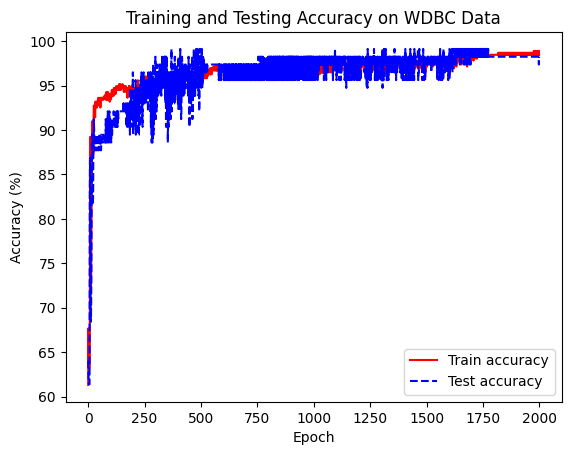

In [26]:
# FINAL EVALUATION
correct = 0
total = len(y_test)

test_inputs = Tensor(X_test)
test_outputs = model.forward(test_inputs)
test_pred_labels = (test_outputs.data >= 0.5).astype(int).ravel()

correct = (test_pred_labels == y_test).sum()
accuracy = (correct / total) * 100
print(f"\nFinal Test Accuracy: {accuracy:.2f}%")

plt.figure()
plt.plot(training_accuracies, label="Train accuracy", color='red')
plt.plot(testing_accuracies, label="Test accuracy", color='blue', linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Testing Accuracy on WDBC Data")
plt.show()